In [1]:
import pickle
import pandas as pd

with open("/home/b4u20/tmp/transformed_features.p", "rb") as f:
    data = pickle.load(f)
data = pd.DataFrame(data)

In [2]:
import numpy as np
pd.set_option('display.max_columns', None)

In [3]:
data.head()

,PMY_DX_CD10,SEC_DX_CD10,X_TYP_PDR,SURG_IND,HOSP_IND,mdg_minimum,mdg_optimum,mdg_max,hosp_out,gd_source,surg_name,surg_type,FTIME_RTRN_WORK_DT,FTIME_ANTIC_RTRN_WORK_DT,ertw_tbd,ertw_days,is_death_flag,is_ertw_from_ee,icd_init,icd_init_sec,OCC_TYPE_CD,DBLTY_EVENT_CD,DIS_DT,LAST_WORK_DT,PRCDR_DT,D_BTH_CLN,FIRST_TREAT_DT,SORCE_AGRMT_ID,SORCE_PRODT_ID,SORCE_PLAN_ID,LAST_WORK_DT_DIS_DT,FIRST_TREAT_DT_DIS_DT,FTIME_ANTIC_RTRN_WORK_DT_DIS_DT,FTIME_RTRN_WORK_DT_DIS_DT,PRCDR_DT_DIS_DT,D_BTH_CLN_DIS_DT,rtw_dt,ID,DIAGNOSIS,JOB,PAID_DURATION,RL_TD,CONDITION_TD,TREATMENT_TD,RL,CONDITION,TREATMENT,SURG_NAME_FROM_ACTIVITIES,ACTIVITIES,DAYS
0,K35.80,None,I,True,True,14.0,14.0,21.0,2027-10-27,UDG,laparoscopic appendectomy with high white bloo...,2,NaT,2022-11-10,False,None,False,True,K,None,S,ILL,2022-10-26,2022-10-25,2022-10-26,1985-04-06,2022-10-26,402810,31,405100116,-1,0.0,15.0,NaN,0.0,-38.0,15.0,22026666,Digestive System,Senior Covenant Compliance Officer,0,NaN,NaN,NaN,None,None,None,laparoscopic appendectomy with high white bloo...,[],19
1,K35.80,None,I,True,True,14.0,14.0,21.0,2027-10-27,UDG,laparoscopic appendectomy with high white bloo...,2,NaT,2022-11-10,False,None,False,True,K,None,S,ILL,2022-10-26,2022-10-25,2022-10-26,1985-04-06,2022-10-26,402810,31,405100116,-1,0.0,15.0,NaN,0.0,-38.0,15.0,22026666,Digestive System,Senior Covenant Compliance Officer,6,NaN,9.0,9.0,None,ACUTE APPENDICITIS,11/10/2022 - 2-3 WEEKS.,laparoscopic appendectomy with high white bloo...,"[[2022-11-04 00:00:00, 11/10/2022 - 2-3 WEEKS....",19
2,K35.80,None,I,True,True,14.0,14.0,21.0,2027-10-27,UDG,laparoscopic appendectomy with high white bloo...,2,NaT,2022-11-10,False,None,False,True,K,None,S,ILL,2022-10-26,2022-10-25,2022-10-26,1985-04-06,2022-10-26,402810,31,405100116,-1,0.0,15.0,NaN,0.0,-38.0,15.0,22026666,Digestive System,Senior Covenant Compliance Officer,6,NaN,9.0,9.0,None,ACUTE APPENDICITIS,11/10/2022 - 2-3 WEEKS.,laparoscopic appendectomy with high white bloo...,"[[2022-11-04 00:00:00, 11/10/2022 - 2-3 WEEKS....",19
3,M79.673,,O,True,False,NaN,NaN,NaN,NaT,MDG,open left foot surgery,1,NaT,2024-11-25,False,None,False,True,M,NaN,L,ILL,2024-10-25,2024-10-24,2024-10-25,1960-08-21,NaT,602846,16,686300166,-1,NaN,31.0,NaN,0.0,-64.0,31.0,25040168,Musculoskeletal/Connective Tissue (excl Back &...,Managerfd,0,NaN,NaN,5.0,None,None,SURGERY THEN RECOVER.,10.25.2024,"[[2024-10-30 00:00:00, SURGERY THEN RECOVER., ...",38
4,M79.673,,O,True,False,NaN,NaN,NaN,NaT,MDG,open left foot surgery,1,NaT,2024-11-25,False,None,False,True,M,NaN,L,ILL,2024-10-25,2024-10-24,2024-10-25,1960-08-21,NaT,602846,16,686300166,-1,NaN,31.0,NaN,0.0,-64.0,31.0,25040168,Musculoskeletal/Connective Tissue (excl Back &...,Managerfd,32,NaN,NaN,5.0,None,None,SURGERY THEN RECOVER.,10.25.2024,"[[2024-10-30 00:00:00, SURGERY THEN RECOVER., ...",38


<Axes: >

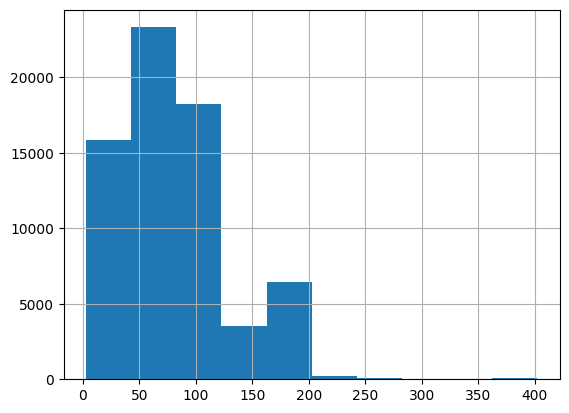

In [4]:
data.DAYS.hist()

In [5]:
data.ID.nunique(), data.shape

(22226, (67716, 50))

In [ ]:
categorical_cols = ["PMY_DX_CD10", "SEC_DX_CD10", "X_TYP_PDR", "surg_type", "icd_init", "icd_init_sec", "OCC_TYPE_CD", "DBLTY_EVENT_CD"]
boolean_cols = ["SURG_IND", "HOSP_IND", "is_ertw_from_ee"]
numerical_cols = ["mdg_minimum", "mdg_optimum", "mdg_max", "ertw_days", "LAST_WORK_DT_DIS_DT", "FIRST_TREAT_DT_DIS_DT", "FTIME_ANTIC_RTRN_WORK_DT_DIS_DT", "FTIME_RTRN_WORK_DT_DIS_DT", "PRCDR_DT_DIS_DT", "D_BTH_CLN_DIS_DT", "rtw_dt", "PAID_DURATION", "RL_TD", "CONDITION_TD", "TREATMENT_TD"]
candidate_cols = ["surg_name", "DIAGNOSIS", "JOB", "SURG_NAME_FROM_ACTIVITIES"] # OCC_TYPE_CD can be moved to this candidate, next experiment
history_cols = ["ACTIVITIES"]

In [ ]:
target_data = data[["ID", "DAYS"] + categorical_cols + boolean_cols + numerical_cols + candidate_cols + history_cols]
target_data.replace({"": "None", None: "None", np.nan: "None"}, inplace=True)
target_data[numerical_cols] = target_data[numerical_cols].replace("None", 1e-5)

In [ ]:
from collections import defaultdict
dup_activity_sameday_info = 0
updated_data = []
for item in target_data.to_dict("records"):
    surg_name = item["surg_name"]
    diagnosis = item["DIAGNOSIS"]
    job = item["JOB"]
    surg_name_by_activity = item["SURG_NAME_FROM_ACTIVITIES"]
    
    candidate_text = f"The surgery name is {surg_name}; the diagnosis is {diagnosis}; the job title is {job}; and the surgery name from activity note is {surg_name_by_activity}."

    activities = item["ACTIVITIES"]
    if not len(activities):
        entry = {
            "timestamp": None,
            "days_ago": 0,
            "CONDITION": None,
            "TREATMENT": None,
            "RL": None,
            "text": "There is no activity notes received."
        }
        history_output = [entry]
    else:
        # Group data by timestamp
        grouped_data = defaultdict(lambda: {"CONDITION": None, "TREATMENT": None, "RL": None})
        for timestamp, value, key in activities:
            if grouped_data[timestamp][key] != value:
                dup_activity_sameday_info+=1
            grouped_data[timestamp][key] = value
            
        # Sort timestamps to determine the most recent one
        sorted_timestamps = sorted(grouped_data.keys())
        most_recent_timestamp = sorted_timestamps[-1]  # The latest date

        # Convert to sorted list format
        history_output = []
        for timestamp in sorted_timestamps:
            days_ago = (most_recent_timestamp - timestamp).days  # Calculate days difference
            entry = {
                "timestamp": timestamp,
                "days_ago": days_ago,
                "CONDITION": grouped_data[timestamp]["CONDITION"],
                "TREATMENT": grouped_data[timestamp]["TREATMENT"],
                "RL": grouped_data[timestamp]["RL"],
                "text": f"The condition is {grouped_data[timestamp]['CONDITION']}, "
                        f"treatment is {grouped_data[timestamp]['TREATMENT']}, "
                        f"restriction and limitations is {grouped_data[timestamp]['RL']}."
            }
            history_output.append(entry)

    updated_data.append({**item, "candidate_text": candidate_text, "history_elems": history_output})
updated_data = pd.DataFrame(updated_data)
updated_data = updated_data.drop(columns=candidate_cols)
dup_activity_sameday_info

100814

In [178]:
updated_data["history_len"] = updated_data["history_elems"].apply(len)
updated_data["ACTIVITIES"] = updated_data["ACTIVITIES"].astype(str)
updated_data.shape

(67716, 32)

In [179]:
updated_data.head(3)

,ID,DAYS,PMY_DX_CD10,SEC_DX_CD10,X_TYP_PDR,surg_type,icd_init,icd_init_sec,OCC_TYPE_CD,DBLTY_EVENT_CD,SURG_IND,HOSP_IND,is_ertw_from_ee,mdg_minimum,mdg_optimum,mdg_max,ertw_days,LAST_WORK_DT_DIS_DT,FIRST_TREAT_DT_DIS_DT,FTIME_ANTIC_RTRN_WORK_DT_DIS_DT,FTIME_RTRN_WORK_DT_DIS_DT,PRCDR_DT_DIS_DT,D_BTH_CLN_DIS_DT,rtw_dt,PAID_DURATION,RL_TD,CONDITION_TD,TREATMENT_TD,ACTIVITIES,candidate_text,history_elems,history_len
0,22026666,19,K35.80,None,I,2,K,None,S,ILL,True,True,True,14.0,14.0,21.0,0.00001,-1,0.0,15.0,0.00001,0.0,-38.0,15.0,0,0.00001,0.00001,0.00001,[],The surgery name is laparoscopic appendectomy ...,"[{'timestamp': None, 'days_ago': 0, 'CONDITION...",1
1,22026666,19,K35.80,None,I,2,K,None,S,ILL,True,True,True,14.0,14.0,21.0,0.00001,-1,0.0,15.0,0.00001,0.0,-38.0,15.0,6,0.00001,9.00000,9.00000,"[[Timestamp('2022-11-04 00:00:00'), '11/10/202...",The surgery name is laparoscopic appendectomy ...,"[{'timestamp': 2022-11-04 00:00:00, 'days_ago'...",1
2,22026666,19,K35.80,None,I,2,K,None,S,ILL,True,True,True,14.0,14.0,21.0,0.00001,-1,0.0,15.0,0.00001,0.0,-38.0,15.0,6,0.00001,9.00000,9.00000,"[[Timestamp('2022-11-04 00:00:00'), '11/10/202...",The surgery name is laparoscopic appendectomy ...,"[{'timestamp': 2022-11-04 00:00:00, 'days_ago'...",1


In [27]:
total_kesy = []
history_len = []
for item in updated_data["ACTIVITIES"].tolist():
    current_times, current_key = [], []
    for each in item:
        time, value, key = each[0], each[1], each[2]
        current_times.append(time)
        current_key.append(key)
    history_len.append(len(set(current_times)))
    total_kesy += current_key

In [28]:
set(total_kesy)

{'CONDITION', 'RL', 'TREATMENT'}

In [29]:
from collections import Counter
Counter(history_len)

Counter({0: 25932,
         1: 26156,
         2: 11973,
         3: 2962,
         4: 574,
         5: 89,
         6: 24,
         7: 3,
         8: 3})

In [143]:
Counter(updated_data["history_len"])

Counter({1: 52088, 2: 11973, 3: 2962, 4: 574, 5: 89, 6: 24, 7: 3, 8: 3})

In [ ]:
# Convert list columns to tuples for deduplication
df_dedup = updated_data.drop_duplicates(subset=[col for col in updated_data.columns if col != "history_elems" and col != "history_len"])

In [152]:
df_dedup.shape, updated_data.shape, df_dedup["ID"].nunique(), updated_data["ID"].nunique()

((49874, 31), (67716, 32), 22226, 22226)

In [ ]:
df_dedup = df_dedup.drop(columns=["ACTIVITIES"])

In [153]:
# split train, test
import numpy as np

# Get unique IDs and shuffle
unique_ids = df_dedup["ID"].unique()
np.random.shuffle(unique_ids)

# Split 80/20
split_idx = int(len(unique_ids) * 0.8)
train_ids, test_ids = unique_ids[:split_idx], unique_ids[split_idx:]

# Assign "data_type" column
df_dedup["data_type"] = np.where(df_dedup["ID"].isin(train_ids), "train", "test")


In [161]:
df_dedup[categorical_cols+boolean_cols] = df_dedup[categorical_cols+boolean_cols].astype("category").apply(lambda x: x.cat.codes)

In [162]:
df_dedup.head(2)

,ID,DAYS,PMY_DX_CD10,SEC_DX_CD10,X_TYP_PDR,surg_type,icd_init,icd_init_sec,OCC_TYPE_CD,DBLTY_EVENT_CD,SURG_IND,HOSP_IND,is_ertw_from_ee,mdg_minimum,mdg_optimum,mdg_max,ertw_days,LAST_WORK_DT_DIS_DT,FIRST_TREAT_DT_DIS_DT,FTIME_ANTIC_RTRN_WORK_DT_DIS_DT,FTIME_RTRN_WORK_DT_DIS_DT,PRCDR_DT_DIS_DT,D_BTH_CLN_DIS_DT,rtw_dt,PAID_DURATION,RL_TD,CONDITION_TD,TREATMENT_TD,candidate_text,history_elems,history_len,data_type
0,22026666,19,1572,2885,1,1,18,24,3,0,1,1,1,14.0,14.0,21.0,0.00001,-1,0.0,15.0,0.00001,0.0,-38.0,15.0,0,0.00001,0.00001,0.00001,The surgery name is laparoscopic appendectomy ...,"[{'timestamp': None, 'days_ago': 0, 'CONDITION...",1,train
1,22026666,19,1572,2885,1,1,18,24,3,0,1,1,1,14.0,14.0,21.0,0.00001,-1,0.0,15.0,0.00001,0.0,-38.0,15.0,6,0.00001,9.00000,9.00000,The surgery name is laparoscopic appendectomy ...,"[{'timestamp': 2022-11-04 00:00:00, 'days_ago'...",1,train


In [171]:
df_dedup.to_pickle("data_for_experiment.pkl")
